In [1]:
%matplotlib inline


# Spectral Unmixing


S. Somnath\ :sup:`1,2`,  R. K. Vasudevan\ :sup:`1,3`
* :sup:`1` Institute for Functional Imaging of Materials
* :sup:`2` Advanced Data and Workflows Group
* :sup:`3` Center for Nanophase Materials Sciences

Oak Ridge National Laboratory, Oak Ridge TN 37831, USA

In this notebook we load some spectral data, and perform basic data analysis, including:
========================================================================================
* KMeans Clustering
* Non-negative Matrix Factorization
* Principal Component Analysis

Software Prerequisites:
=======================
* Standard distribution of **Anaconda** (includes numpy, scipy, matplotlib and sci-kit learn)
* **pycroscopy** : Though pycroscopy is mainly used here for plotting purposes only, it's true capabilities
  are realized through the ability to seamlessly perform these analyses on any imaging dataset (regardless
  of origin, size, complexity) and storing the results back into the same dataset among other things




In [2]:
#Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# The package used for creating and manipulating HDF5 files:
import h5py

# Plotting and visualization:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for downloading files:
import wget
import os

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

# finally import pycroscopy:
import pycroscopy as px

"""
  
"""

'\n  \n'

The Data
========

In this example, we will work on a **Electron Energy-Loss Spectrum (EELS)** imaging dataset
acquired from probe aberration corrected Scanning Transmittion Electron Microscopes (AC-STEM). In this dataset, a spectra was colllected for each position in a two
dimensional grid of spatial locations. Thus, this is a three dimensional dataset that has been flattened to a two
dimensional matrix in accordance with the pycroscopy data format.

Fortunately, all statistical analysis, machine learning, spectral unmixing algorithms, etc. only accept data that is
formatted in the same manner of [position x spectra] in a two dimensional matrix.

We will begin by opening H5 dataset we have tranlated from DM3 file.



In [10]:
data_file_path = 'EELS spectrum image.h5'
# :
hdf = px.ioHDF5(data_file_path)
h5_file = hdf.file

print('Contents of data file:')
print('----------------------')
px.hdf_utils.print_tree(h5_file)
print('----------------------')

h5_meas_grp = h5_file['Measurement_000']
parm_dict=px.hdf_utils.get_attributes(h5_meas_grp)

print('The attibutes include:')
for key in parm_dict:
    print(key,':',parm_dict[key])


# Getting a reference to the main dataset:
h5_main = h5_meas_grp['Channel_000/Raw_Data']
h5_proc = h5_meas_grp['Channel_000/Processed/Processed_Data']

# Extracting some basic parameters:
num_rows = px.hdf_utils.get_attr(h5_meas_grp,'num_rows')
num_cols = px.hdf_utils.get_attr(h5_meas_grp,'num_cols')
#spec_vals = px.hdf_utils.get_attr(h5_meas_grp,'spec_axis')
new_spec_vals = px.hdf_utils.getAuxData(h5_proc,'Spectroscopic_Values')[0][0]

print('Data currently of shape:', h5_main.shape)

print(np.shape(new_spec_vals))
x_label = 'Energy Loss (eV)'
y_label = 'Counts'


Contents of data file:
----------------------
/
Measurement_000
Measurement_000/Channel_000
Measurement_000/Channel_000/Position_Indices
Measurement_000/Channel_000/Position_Values
Measurement_000/Channel_000/Processed
Measurement_000/Channel_000/Processed/Position_Indices
Measurement_000/Channel_000/Processed/Position_Values
Measurement_000/Channel_000/Processed/Processed_Data
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000/Component_Indices
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000/S
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000/U
Measurement_000/Channel_000/Processed/Processed_Data-SVD_000/V
Measurement_000/Channel_000/Processed/Spectroscopic_Indices
Measurement_000/Channel_000/Processed/Spectroscopic_Values
Measurement_000/Channel_000/Processed/Thickness
Measurement_000/Channel_000/Processed/Zero_Loss_Peak
Measurement_000/Channel_000/Raw_Data
Measurement_000/Channel_000/Spect

array([ -5.60000008,  -5.55000008,  -5.50000008, ...,  60.75000091,
        60.80000091,  60.85000091])

Singular Value Decomposition (SVD)
=====================================

SVD is an eigenvector decomposition that is defined statistically, and therefore typically produces
non-physical eigenvectors. Consequently, the interpretation of eigenvectors and abundance maps from
SVD requires care and caution in interpretation. Nontheless, it is a good method for quickly
visualizing the major trends in the dataset since the resultant eigenvectors are sorted in descending
order of variance or importance. Furthermore, SVD is also very well suited for data cleaning through
the reconstruction of the dataset using only the first N (most significant) components.

SVD results in three matrices:
* V - Eigenvectors sorted by variance in descending order
* U - corresponding bundance maps
* S - Variance or importance of each of these components

Advantage of pycroscopy:
------------------------
Notice that we are working with a complex valued dataset. Passing the complex values as is to SVD would result in
complex valued eigenvectors / endmembers as well as abundance maps. Complex valued abundance maps are not physical.
Thus, one would need to restructure the data such that it is real-valued only.

One solution is to stack the real value followed by the magnitude of the imaginary component before passing to SVD.
After SVD, the real-valued eigenvectors would need to be treated as the concatenation of the real and imaginary
components. So, the eigenvectors would need to be restructured to get back the complex valued eigenvectors.

**Pycroscopy handles all these data transformations (both for the source dataset and the eigenvectors)
automatically.**  In general, pycroscopy handles compund / complex valued datasets everywhere possible

Furthermore, while it is not discussed in this example, pycroscopy also writes back the results from SVD back to
the same source h5 file including all relevant links to the source dataset and other ancillary datasets



Performing SVD decomposition
SVD took 0.25 seconds.  Writing results to file.


(<matplotlib.figure.Figure at 0x36bf6a0>,
 <matplotlib.axes._axes.Axes at 0xbfdf940>)

(<matplotlib.figure.Figure at 0xbaa1d68>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C0B68D0>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C9DC2B0>]], dtype=object))

(<matplotlib.figure.Figure at 0xbcba4e0>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000CAF9780>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x000000000CC97A20>]], dtype=object))

(<matplotlib.figure.Figure at 0xc9dcdd8>,
 <mpl_toolkits.axes_grid1.axes_grid.ImageGrid at 0xe953518>)

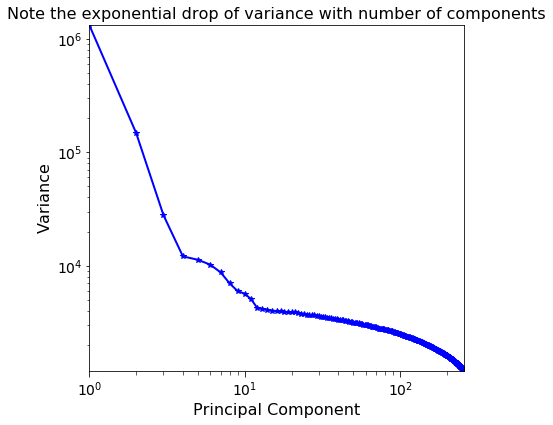

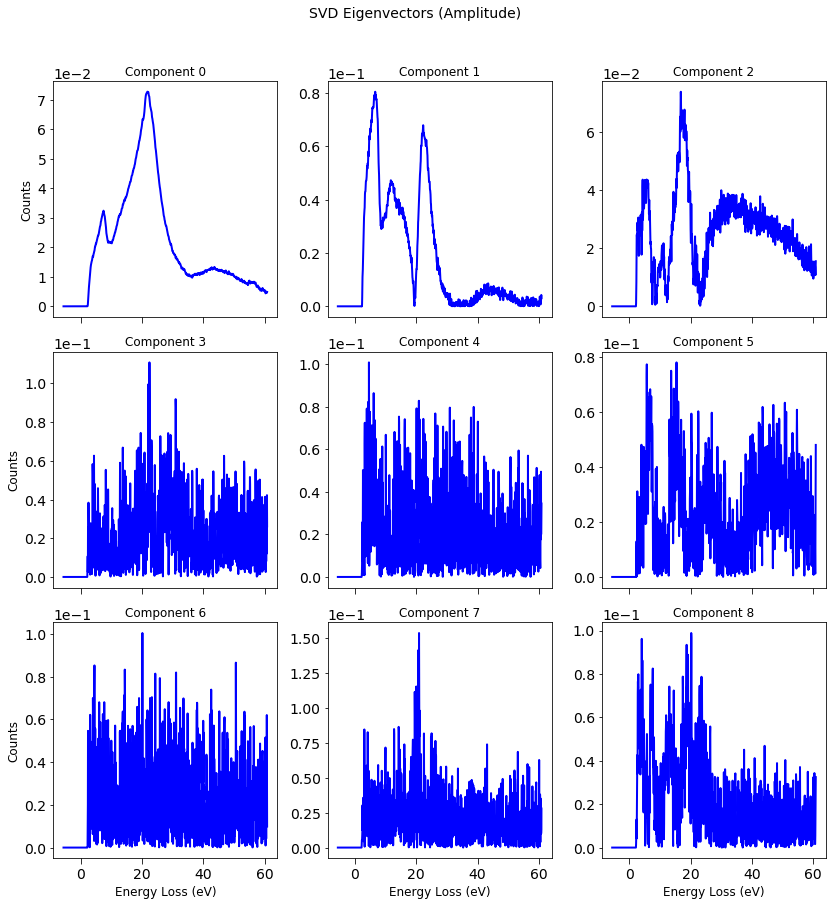

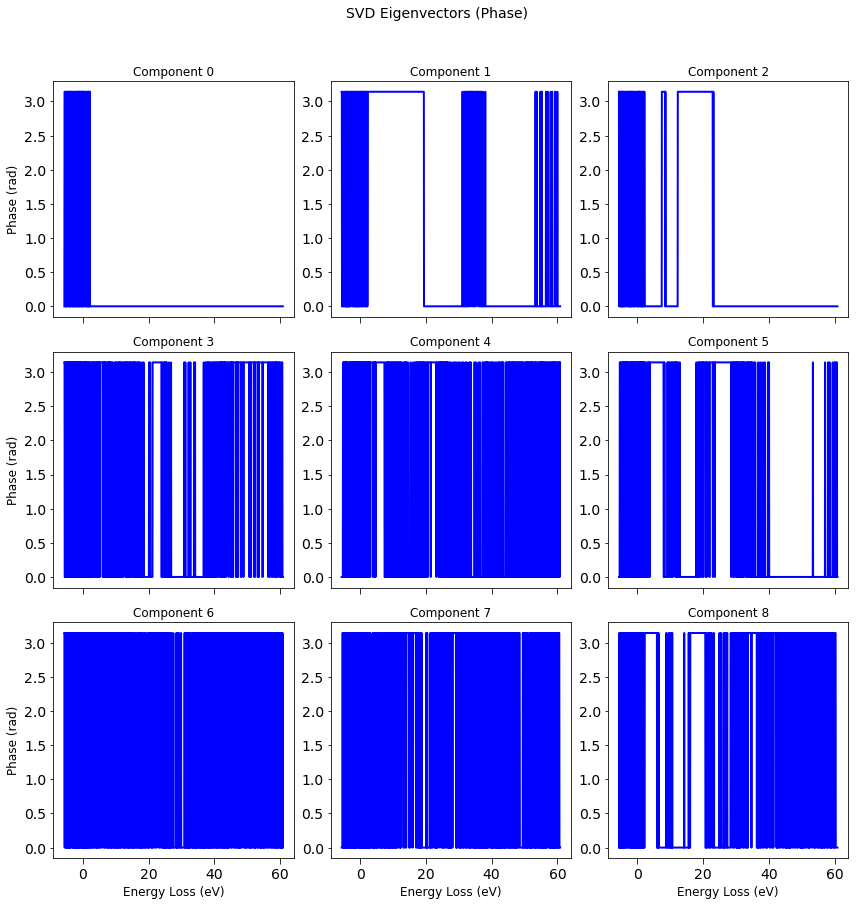

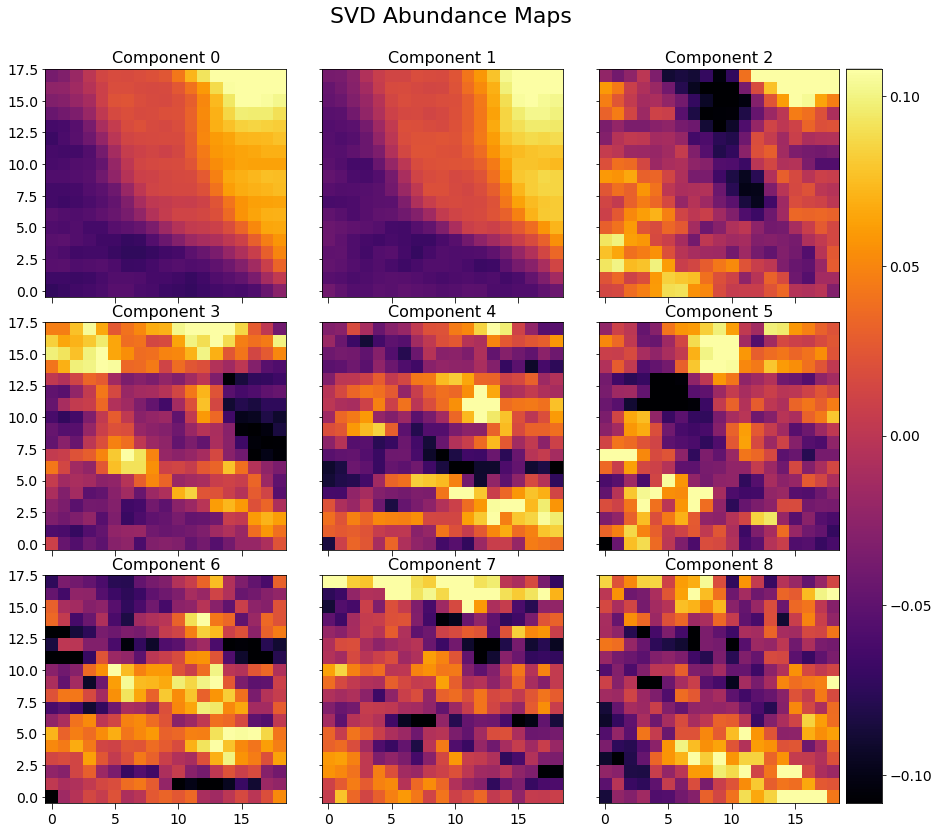

In [11]:
#h5_svd_group = px.doSVD(h5_main, num_comps=256)
h5_svd_group = px.doSVD(h5_proc, num_comps=256)

h5_u = h5_svd_group['U']
h5_v = h5_svd_group['V']
h5_s = h5_svd_group['S']

# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols, -1))

# Visualize the variance / statistical importance of each component:
px.plot_utils.plotScree(h5_s, title='Note the exponential drop of variance with number of components')

# Visualize the eigenvectors:
first_evecs = h5_v[:9, :]

px.plot_utils.plot_loops(new_spec_vals, np.abs(first_evecs), x_label=x_label, y_label=y_label, plots_on_side=3,
                         subtitles='Component', title='SVD Eigenvectors (Amplitude)', evenly_spaced=False)
px.plot_utils.plot_loops(new_spec_vals, np.angle(first_evecs), x_label=x_label, y_label='Phase (rad)', plots_on_side=3,
                         subtitles='Component', title='SVD Eigenvectors (Phase)', evenly_spaced=False)

# Visualize the abundance maps:
px.plot_utils.plot_map_stack(abun_maps, num_comps=9, heading='SVD Abundance Maps',
                             color_bar_mode='single', cmap='inferno')

In [ ]:
np.shape(h5_u[()])

In [ ]:
sort_proc = np.sort(h5_proc[()], axis=None)
print(sort_proc[-12500:-1])

In [ ]:
plt.plot(h5_proc[332,:])

In [ ]:
sort_proc = np.sort(h5_proc[337,:], axis=None)
print(sort_proc[-100:-1])

In [ ]:
h5_proc[330,:]

In [ ]:
for i in range(3):
    print('')

In [ ]:
px.plot_utils.plot_loops(spec_vals, np.abs(first_evecs), x_label=x_label, y_label=y_label, plots_on_side=3,
                         subtitles='Component', title='SVD Eigenvectors (Amplitude)', evenly_spaced=False)

In [ ]:
np.shape(spec_vals)

In [ ]:
px.hdf_utils.get_attributes(h5_main)

In [ ]:
px.hdf_utils.get_attributes(h5_meas_grp)

In [ ]:
px.hdf_utils.getAuxData(h5_main,'Spectroscopic_Values')[0]

In [ ]:
px.hdf_utils.get_attributes(h5_main)